In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

from sqlalchemy import create_engine
from loguru import logger

import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect, detect_langs

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder

from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

# Recommendation System

Development of a recommendation service that will return posts for each user at any time based on previously liked texts.

The quality of the written service is evaluated in a checker based on hidden data. The set of users is fixed and no new ones will appear. Application should process the request in less than 0.5 seconds.

### Downloading data

#### user_data

In [2]:
user_info = pd.read_sql(
    """SELECT * FROM public.user_data""",
    con = "postgresql://...."
          "postgres....."
)

user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


#### post_text_df

In [3]:
post_text_df = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    con = "postgresql://...."
          "postgres....."
)

post_text_df.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


#### feed_data

Almost 77 mln rows. Due to memory issues we are going to use only 5 mln.

Action column includes two values: 'view' and 'like'. We can drop 'like" value because 'view' == 1 means that user instantly liked the post after 'view' action and like rows are just empty. 

In [4]:
query = """ SELECT * FROM public.feed_data where action='view' LIMIT 5000000 """

def chunks_feed(query):
    engine = create_engine(
    con = "postgresql://...."
          "postgres....."
    )
    conn = engine.connect().execution_options(stream_results=True)

    chunks = []
    for chunk_dateframe in pd.read_sql(query, conn, chunksize=500000):
        chunks.append(chunk_dateframe)
        logger.info(f"Got chunk: {len(chunk_dateframe)}")
    conn.close()
    
    return pd.concat(chunks, ignore_index=True)
    
feed_data = chunks_feed(query)

2022-10-03 16:21:10.924 | INFO     | __main__:chunks_feed:13 - Got chunk: 500000
2022-10-03 16:21:13.964 | INFO     | __main__:chunks_feed:13 - Got chunk: 500000
2022-10-03 16:21:16.754 | INFO     | __main__:chunks_feed:13 - Got chunk: 500000
2022-10-03 16:21:19.619 | INFO     | __main__:chunks_feed:13 - Got chunk: 500000
2022-10-03 16:21:22.294 | INFO     | __main__:chunks_feed:13 - Got chunk: 500000
2022-10-03 16:21:25.521 | INFO     | __main__:chunks_feed:13 - Got chunk: 500000
2022-10-03 16:21:28.011 | INFO     | __main__:chunks_feed:13 - Got chunk: 500000
2022-10-03 16:21:30.822 | INFO     | __main__:chunks_feed:13 - Got chunk: 500000
2022-10-03 16:21:33.731 | INFO     | __main__:chunks_feed:13 - Got chunk: 500000
2022-10-03 16:21:36.379 | INFO     | __main__:chunks_feed:13 - Got chunk: 500000


Action column includes two values: 'view' and 'like'. We can drop 'like" value because target == 1 means that user instantly liked the post after 'view' action. 

In [5]:
feed_data.shape

(5000000, 5)

Posts can remain relevant for several months, so it makes sense to dive into the analysis of the texts themselves.

In [6]:
post_text_time = pd.merge(post_text_df, feed_data[['timestamp', 'post_id']], on='post_id', how='left')
print("the earliest date listed: ", min(post_text_time['timestamp']))
print("the last date listed", max(post_text_time['timestamp']))

print("the first time 'UK economy facing major risks' post was viewed at: ",
      min(post_text_time.loc[post_text_time['post_id'] ==1]['timestamp']))
print("and the last time at:",
      max(post_text_time.loc[post_text_time['post_id'] ==1]['timestamp']))

the earliest date listed:  2021-10-01 06:05:25
the last date listed 2021-12-29 23:51:06
the first time 'UK economy facing major risks' post was viewed at:  2021-10-01 06:42:49
and the last time at: 2021-12-29 21:54:52


### Cosine Similarity

[Cosine similarity](https://www.sciencedirect.com/topics/computer-science/cosine-similarity) is a measure of similarity between two sequences of numbers. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction. This method can be used as a measurement of how similar are posts in a given social network. 

First of all, I applied pretrained huggingface [model]('https://huggingface.co/sentence-transformers/all-mpnet-base-v2') to convert the available text into the form of vectors. This is a sentence-transformers model: it maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search.

Then I calculated cosine similarity.

In [7]:
text_data = np.array(post_text_df.text)
model = SentenceTransformer('all-mpnet-base-v2', device='cuda')
embeddings = model.encode(text_data, show_progress_bar=False)

In [8]:
X = np.array(embeddings)
cos_sim_data = pd.DataFrame(cosine_similarity(X))
cos_sim_data.head()

,0,1,2,3,4,5,6,7,8,9,...,7013,7014,7015,7016,7017,7018,7019,7020,7021,7022
0,1.000000,0.266963,0.336132,0.247778,0.103514,0.135540,0.181818,0.228832,0.166143,0.256785,...,0.010544,0.006330,-0.012628,0.012558,0.049034,-0.036452,-0.017714,0.030553,-0.044170,-0.030794
1,0.266963,1.000000,0.242468,0.182985,0.066400,0.093780,0.157890,0.058365,0.198214,0.093983,...,0.018904,0.128026,-0.001986,-0.034519,0.041126,-0.079797,-0.063141,0.041046,-0.087762,0.069174
2,0.336132,0.242468,1.000000,0.251606,0.165769,0.231744,0.154260,0.090189,0.266783,0.325433,...,-0.003619,-0.134123,0.079599,0.007925,0.084929,-0.009916,-0.037289,0.073485,-0.093061,0.025176
3,0.247778,0.182985,0.251606,1.000000,0.081216,0.103222,0.194865,0.157927,0.284308,0.311190,...,-0.043732,-0.010432,-0.008100,-0.037064,0.007146,0.018267,-0.041638,0.058529,-0.026296,0.025912
4,0.103514,0.066400,0.165769,0.081216,1.000000,0.154496,0.382021,0.147056,0.077830,0.281447,...,0.005314,-0.067795,0.076423,-0.013206,-0.039245,-0.056741,0.034747,0.048981,0.035171,0.027130


Let's simulate a recommender system: the user likes a certain post, and we show n similar posts

In [9]:
class text_style:
    
    BOLD = '\033[1m'
    RED = '\033[91m'
    END = '\033[0m'

def give_recommendations(df, index, limit, print_res = False):
    index_recomm = cos_sim_data.loc[index].sort_values(ascending=False).index.tolist()[1:limit+1]
    posts_recomm = df['text'].loc[index_recomm].values
    topic_recomm = df['topic'].loc[index_recomm].values
    #res = {'Posts':posts_recomm, 'Index':index_recomm}
    res = {'Topic': topic_recomm,'Index':index_recomm}
    if print_res == True:
        print(text_style.BOLD + "Liked post" + text_style.END)
        print(f"{df['text'].loc[index][0:499]} \n")
        k=0
        for post in posts_recomm:
            k += 1
            print(text_style.BOLD + f"The number {k} recommended post: " + text_style.END)
            print(post[0:499])
    return res

In [10]:
give_recommendations(post_text_df, 5, 4, print_res = True)

Liked post
Insurance bosses plead guilty

Another three US insurance executives have pleaded guilty to fraud charges stemming from an ongoing investigation into industry malpractice.

Two executives from American International Group (AIG) and one from Marsh & McLennan were the latest. The investigation by New York attorney general Eliot Spitzer has now obtained nine guilty pleas. The highest ranking executive pleading guilty on Tuesday was former Marsh senior vice president Joshua Bewlay.

He admitted one 

The number 1 recommended post: 
Marsh executive in guilty plea

An executive at US insurance firm Marsh & McLennan has pleaded guilty to criminal charges in connection with an ongoing fraud and bid-rigging probe.

New York Attorney General Elliot Spitzer said senior vice president Robert Stearns had pleaded guilty to scheming to defraud. The offence carries a sentence of 16 months to four years in state prison. Mr Spitzers office added Mr Stearns had also agreed to testify in future

{'Topic': array(['business', 'business', 'business', 'business'], dtype=object),
 'Index': [220, 601, 113, 49]}

### PCA

We really want to reduce the size of the text dataset so let's find the best number of principal components.

Text(0.5, 1.0, 'Scree Plot')

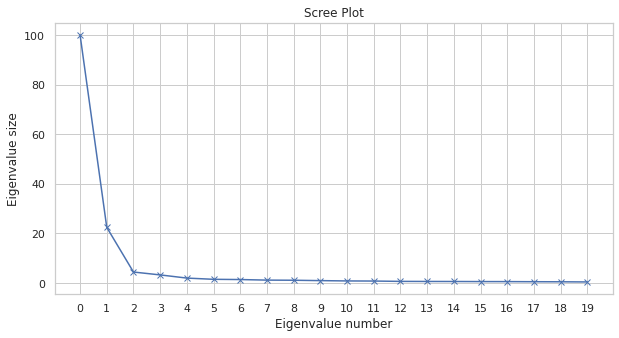

In [11]:
pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(cos_sim_data)

plt.figure(figsize=(10,5))
plt.plot(pca.explained_variance_, marker='x')
plt.xlabel("Eigenvalue number")
plt.xticks(range(0, 20))
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

Seems like 4 components are enough

In [12]:
pca_data = pd.DataFrame(pca_decomp).iloc[: , :4]
pca_data.columns = ['first_component', 'second_component', 'third_component', 'fourth_component']
pca_data.head()

,first_component,second_component,third_component,fourth_component
0,-8.284286,-4.334571,4.702188,4.076097
1,-10.601251,1.118376,2.763184,1.356052
2,-8.938816,-2.717523,-0.961379,3.768424
3,-7.565113,-4.303687,-0.366947,3.052176
4,-6.464598,-7.375361,-3.664510,1.596397


Principal Component Analysis plot showed a clear cluster separation of 'Covid' and 'Movie' posts while separating other topics proved more difficult.

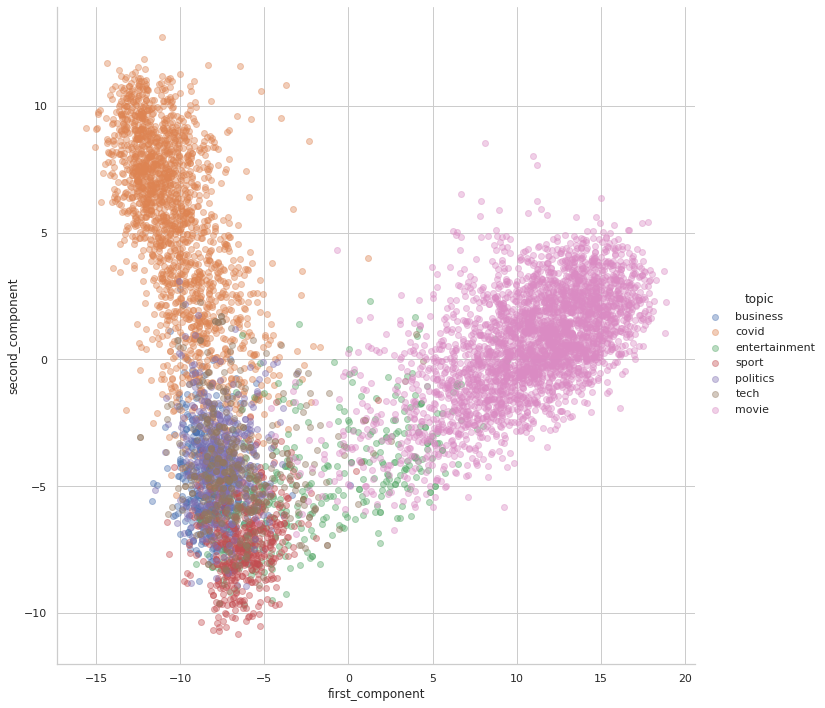

In [13]:
posts_info = pd.concat((post_text_df, pca_data), axis=1)

sns.FacetGrid(posts_info,
              hue="topic",
              size=10).map(plt.scatter,
                           'first_component',
                           'second_component',
                           alpha=0.4).add_legend()
plt.show()

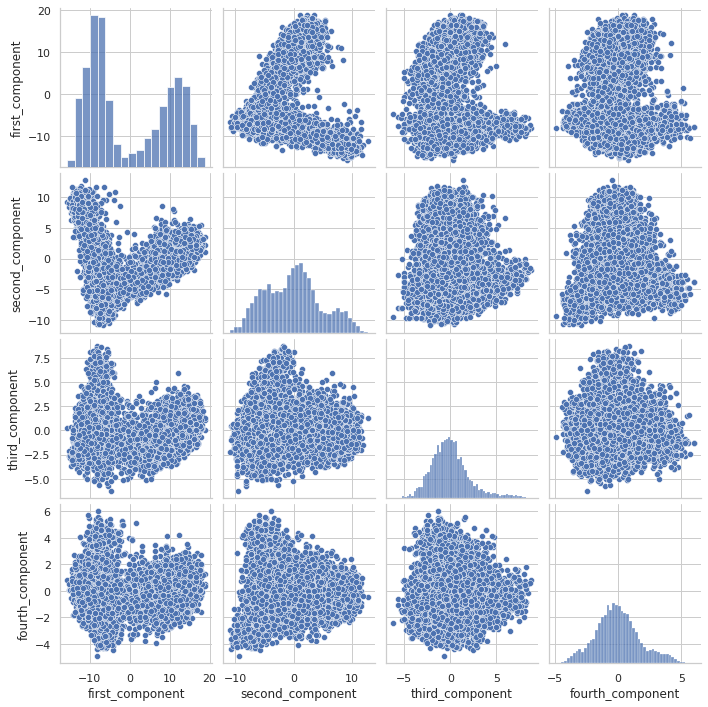

In [14]:
sns.pairplot(pca_data)

### Sentiment Analysis

The idea is to detect sentiment (negative, neutral and positive) in text and then use it to make recommendations. About 60% of all posts are positive and 30% are negative.

In [15]:
sentim_analyzer = SentimentIntensityAnalyzer()
posts_info['compound'] = [sentim_analyzer.polarity_scores(x)['compound'] for x in posts_info['text']]

In [16]:
def comp_comvert(row):
    
    if row['compound'] >= 0.05:
        return 'Positive'
    elif row['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
        
    
posts_info['sentiment'] = posts_info.apply(comp_comvert, axis=1)
posts_info.sentiment.value_counts(normalize=True)

Positive    0.592767
Negative    0.307988
Neutral     0.099245
Name: sentiment, dtype: float64

### Word and Paragraph Count

The length and style can affect perception of the text.

In [17]:
posts_info['word_count'] = posts_info['text'].apply(lambda x: len(x.split()))
posts_info['paragraph_count'] = posts_info['text'].apply(lambda x: len(x.split('\n')))

<AxesSubplot:xlabel='word_count'>

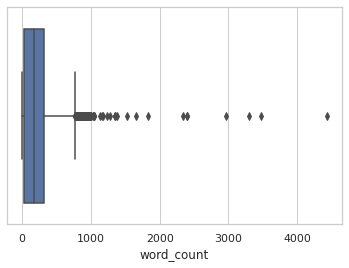

In [18]:
sns.boxplot(data=posts_info, x="word_count")

<AxesSubplot:xlabel='paragraph_count'>

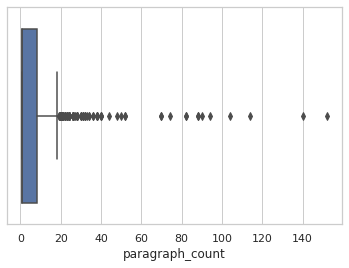

In [19]:
sns.boxplot(data=posts_info, x="paragraph_count")

### Language Detection

English dominates, so there is not much point in using this feature.

In [20]:
def detect_cached(t):
    try:
        return detect(t)
    except:
        return 'unknown'
    
posts_info['language'] = posts_info["text"].apply(lambda x: detect_cached(x))
posts_info['language'].value_counts()

en         7004
id            4
nl            3
af            2
tl            1
it            1
ro            1
unknown       1
de            1
fr            1
es            1
so            1
vi            1
et            1
Name: language, dtype: int64

In [21]:
posts_info.drop('language', axis=1, inplace=True)

### Creating dataframe for training

In [22]:
df = pd.merge(feed_data, posts_info, on='post_id', how='left')
df = pd.merge(df, user_info, on='user_id', how='left')

In [23]:
# extracting datetime features using datetime module 

df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['month'] = pd.to_datetime(df['timestamp']).dt.month
df['weekday'] = pd.to_datetime(df['timestamp']).dt.dayofweek
df['week'] = pd.to_datetime(df['timestamp']).dt.isocalendar().week

df = df.drop(['action', 'text', 'sentiment'], axis=1)
df = df.set_index(['user_id', 'post_id'])

df.head()

timestamp  target     topic  first_component  \
user_id post_id                                                          
56197   2552    2021-11-03 10:36:37       0     covid        -8.882162   
        4017    2021-11-03 10:36:48       1     covid       -11.471533   
        190     2021-11-03 10:37:31       0  business        -7.372693   
        345     2021-11-03 10:38:55       0  business        -7.984270   
        6064    2021-11-03 10:39:15       1     movie        10.481509   

                 second_component  third_component  fourth_component  \
user_id post_id                                                        
56197   2552             8.268464        -1.367898         -1.380433   
        4017             8.947657        -0.136976          0.218054   
        190             -7.417932        -0.140135          3.160488   
        345             -6.077614        -0.175297          3.351430   
        6064             1.085864        -0.594706         -1.484159   

                 compound  word_count  paragraph_count  ...  age  country  \
user_id post_id                                         ...                 
56197   2552       0.7332          19                3  ...   46   Russia   
        4017       0.2500          18                1  ...   46   Russia   
        190        0.8860         217                8  ...   46   Russia   
        345        0.9969         304               12  ...   46   Russia   
        6064       0.9646         572                1  ...   46   Russia   

                      city exp_group       os source hour  month  weekday  \
user_id post_id                                                             
56197   2552     Astrakhan         1  Android    ads   10     11        2   
        4017     Astrakhan         1  Android    ads   10     11        2   
        190      Astrakhan         1  Android    ads   10     11        2   
        345      Astrakhan         1  Android    ads   10     11        2   
        6064     Astrakhan         1  Android    ads   10     11        2   

                 week  
user_id post_id        
56197   2552       44  
        4017       44  
        190        44  
        345        44  
        6064       44  

[5 rows x 21 columns]

### It's training time!

In [24]:
object_cols = ['topic', 'gender', 'country', 'city',
               'exp_group', 'hour', 'month', 'week',
               'weekday', 'os', 'source']

df[object_cols] = df[object_cols].astype(object)

In [25]:
df_train = df[df.timestamp < '2021-12-14']
df_test = df[df.timestamp >= '2021-12-14']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((4166716,), (833284,))

Prediction limit of 0.5 seconds per request - the main snag in the development of this recommendation service. It's better to keep model simple.

#### LightGBM classifier

First you need to preprocess the data and only then train the model so I implemented pipeline: `OneHotEncoder` for object features with small amount of values and `MeanTargetEncoder` for the rest.

In [26]:
cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
]

col_transform = ColumnTransformer(transformers=t)

In [27]:
pipe_lgb = Pipeline([("column_transformer",
                     col_transform),
                     
                    ("decision_tree", 
                     lgb.LGBMClassifier(device = 'gpu',
                                        gpu_platform_id = 0,
                                        gpu_device_id = 0,
                                        random_state = 1))])

pipe_lgb.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [8, 16, 13, 14]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 10, 11, 12, 15, 18,
                                                   17])])),
                ('decision_tree',
                 LGBMClassifier(device='gpu', gpu_device_id=0,
                                gpu_platform_id=0, random_state=1))])

In [28]:
print(f"Train AUC ROC: {roc_auc_score(y_train, pipe_lgb.predict_proba(X_train)[:, 1])}")
print(f"Test AUC ROC: {roc_auc_score(y_test, pipe_lgb.predict_proba(X_test)[:, 1])}")

Train AUC ROC: 0.6560914959321433
Test AUC ROC: 0.6341050319017791


#### CatBoostClassifier

CatBoostClassifier can handle categorical features directly without encoding and chooses hyperparameters on its own.

In [29]:
cb_model = CatBoostClassifier(task_type="GPU", silent=True)


cb_model.fit(X_train, y_train, object_cols)

In [30]:
print(f"Train AUC ROC: {roc_auc_score(y_train, cb_model.predict_proba(X_train)[:, 1])}")
print(f"Test AUC ROC: {roc_auc_score(y_test, cb_model.predict_proba(X_test)[:, 1])}")

Train AUC ROC: 0.6946901176423667
Test AUC ROC: 0.6638858302234011


After hyperparameter optimization with GridSearch it was possible to slightly improve the quality.

In [31]:
cb_model_2 = CatBoostClassifier(learning_rate=0.021316,
                                depth=6,
                                iterations=2000,
                                task_type="GPU",
                                verbose=500)

cb_model_2.fit(X_train, y_train, object_cols)

0:	learn: 0.6759986	total: 264ms	remaining: 8m 47s
500:	learn: 0.3359973	total: 2m 36s	remaining: 7m 48s
1000:	learn: 0.3344431	total: 5m 14s	remaining: 5m 14s
1500:	learn: 0.3336208	total: 7m 53s	remaining: 2m 37s
1999:	learn: 0.3330387	total: 10m 32s	remaining: 0us


In [32]:
print(f"Train score: {roc_auc_score(y_train, cb_model_2.predict_proba(X_train)[:, 1])}")
print(f"Test score: {roc_auc_score(y_test, cb_model_2.predict_proba(X_test)[:, 1])}")

Train score: 0.7002115668589735
Test score: 0.6668828746846677


In [33]:
cb_model_2.save_model(
    'catboost_model_2',
    format="cbm"                  
)

#### The impact of a feature on the prediction results

<AxesSubplot:xlabel='feature_importance', ylabel='feature_names'>

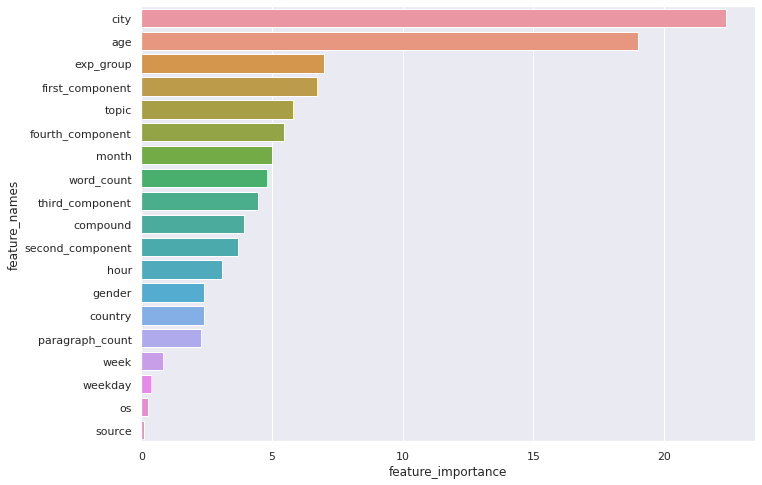

In [34]:
feature_names = X_train.columns
feature_importance = cb_model_2.feature_importances_
forplot= pd.DataFrame({'feature_names':feature_names,
                       'feature_importance':feature_importance}).sort_values('feature_importance', ascending=False)
sns.set(rc={'figure.figsize':(11,8)})
sns.barplot(x=forplot.feature_importance, y=forplot.feature_names)

### Implementation

Uploading features to database so that it is possible to use a ready-made model

In [35]:
posts_info.to_sql(    
   "posts_info_features_mike",                    
    con = "postgresql://...."
          "postgres....."                   
    schema="public",                   
    if_exists='replace'            
   )                

Finally I implemented recommendation service that loads the data, makes a prediction for the user, deletes already liked posts, sorts the predictions by probability, and gives the user the post with the highest value. The quality of the written algorithm is checked on hidden data.

✅ the model works well, your quality is 0.602